In [11]:
"""
This script is for cleaning and analyzing a dataset related to a cafe's transactions.
It includes handling missing values, replacing erroneous entries, and creating new columns based on existing data.
The dataset is expected to have columns like 'Payment_Method', 'Location', 'Transaction_Date',
'Item', 'Quantity', and 'Transaction_Status'.
The script also includes comments indicating the handling of missing data and the rationale behind each step.
The final output will be a cleaned DataFrame ready for further analysis or modeling.
you can find the dataset at https://www.kaggle.com/datasets/ahmedmohamed2003/cafe-sales-dirty-data-for-cleaning-training
"""

"\nThis script is for cleaning and analyzing a dataset related to a cafe's transactions.\nIt includes handling missing values, replacing erroneous entries, and creating new columns based on existing data.\nThe dataset is expected to have columns like 'Payment_Method', 'Location', 'Transaction_Date',\n'Item', 'Quantity', and 'Transaction_Status'.\nThe script also includes comments indicating the handling of missing data and the rationale behind each step.\nThe final output will be a cleaned DataFrame ready for further analysis or modeling.\nyou can find the dataset at https://www.kaggle.com/datasets/ahmedmohamed2003/cafe-sales-dirty-data-for-cleaning-training\n"

### __Importing the libaries__ 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

### __Reading the data__ 

In [13]:
path=r"d:\Project  EDA\Datasets\Dataset_before cleaning.csv"
df=pd.read_csv(path)


### __Checking the data__ 

#####  The data has null values and the data types needs to be converted to its correct data types 

In [14]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 312.6+ KB


##### There is 3 types of missing data  (Unknown,Error,direct null value)

In [15]:
df.head

<bound method NDFrame.head of      Transaction ID      Item Quantity Price Per Unit Total Spent  \
0       TXN_1961373    Coffee        2            2.0         4.0   
1       TXN_4977031      Cake        4            3.0        12.0   
2       TXN_4271903    Cookie        4            1.0       ERROR   
3       TXN_7034554     Salad        2            5.0        10.0   
4       TXN_3160411    Coffee        2            2.0         4.0   
...             ...       ...      ...            ...         ...   
9995    TXN_7672686    Coffee        2            2.0         4.0   
9996    TXN_9659401       NaN        3            NaN         3.0   
9997    TXN_5255387    Coffee        4            2.0         8.0   
9998    TXN_7695629    Cookie        3            NaN         3.0   
9999    TXN_6170729  Sandwich        3            4.0        12.0   

      Payment Method  Location Transaction Date  
0        Credit Card  Takeaway       2023-09-08  
1               Cash  In-store       2023

### __Cleaning the Data__

##### Dropping the Transaction ID column as it is not a feature 

In [16]:
df.drop(columns=['Transaction ID'], inplace=True) 

##### Renaming the columns 

In [17]:
df.rename(columns={'Transaction Date': 'Transaction_Date'},inplace=True)
df.rename(columns={'Payment Method': 'Payment_Method'},inplace=True)
df.rename(columns={'Total Spent': 'Total_Spent'},inplace=True)
df.rename(columns={'Price Per Unit': 'Unit_Price'},inplace=True)


##### Replacing ERRORS and UNKNOWN with 0 to be able to convert them into float

In [18]:
df.loc[df['Quantity'] == 'ERROR', 'Quantity'] = 0
df.loc[df['Quantity'] == 'UNKNOWN', 'Quantity'] = 0
df.loc[df['Total_Spent'] == 'ERROR', 'Total_Spent'] = 0
df.loc[df['Total_Spent'] == 'UNKNOWN', 'Total_Spent'] = 0
df.loc[df['Unit_Price'] == 'ERROR', 'Unit_Price'] = 0
df.loc[df['Unit_Price'] == 'UNKNOWN', 'Unit_Price'] = 0
df.fillna(0, inplace=True) # replace NaN values with 0 to deal with them easily later


##### Converting each data 

In [19]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')
df['Quantity'] = df['Quantity'].astype(int)
df['Total_Spent'] = df['Total_Spent'].astype(float)
df['Unit_Price'] = df['Unit_Price'].astype(float)



##### Creating Transaction status column 

In [20]:

df['Transaction_Status'] = np.where(df['Quantity'] == 0, 'Cancelled', 'Successful') # if quantity is zero, then transaction is 'Cancelled', otherwise successful

### __Dealing with missing data__ 


| MCAR  | Reason |How it will be handled|             
|---------|------|-------------------------------------------------------------------------|            
| Items  |The missing values (UNKNOWN or ERROR or 0) in the Item column seem to be random occurrences|Will be filled using a map of item to price unit|  
| Unit price  |The missing values (UNKNOWN or ERROR or 0) in the Item column seem to be random occurrences|Will be filled using a map of price to item unit|                        
| Location | The Location column has missing data (UNKNOWN or ERROR or 0) that seems to be random|Will use proportional imputation using  local mode| 
| Transaction Date | The Location column has missing data at random|Dropping|         

##### Creating a map for filling null values of item using unit price

In [21]:
price_to_item_map = df.groupby('Unit_Price')['Item'].apply( # it will create a mapping of Unit_Price to Item but there still will have some null values if there are no items for a specific price
    lambda x: x.mode()[0] if not x.mode().empty else None
).to_dict() 
price_to_item_map.pop(0)  # Remove the entry for price 0 as it was wrong
price_to_item_map

{1.0: 'Cookie',
 1.5: 'Tea',
 2.0: 'Coffee',
 3.0: 'Juice',
 4.0: 'Sandwich',
 5.0: 'Salad'}

##### Filling Item column using price to item map 

In [22]:
df.loc[df['Item'] == 'UNKNOWN', 'Item'] = df.loc[df['Item'] == 'UNKNOWN', 'Unit_Price'].map(price_to_item_map)
df.loc[df['Item'] == 'ERROR', 'Item'] = df.loc[df['Item'] == 'ERROR', 'Unit_Price'].map(price_to_item_map)
df.loc[df['Item'] == 0, 'Item'] = df.loc[df['Item'] == 0, 'Unit_Price'].map(price_to_item_map)
df['Item'] = df['Item'].fillna(df['Unit_Price'].map(price_to_item_map)) 
df.dropna(subset=['Item'], inplace=True)  # Drop rows that couldnt be mapped from price to item

##### Creating a map for filling null values of unit price  using item

In [23]:
item_to_price_map = df.groupby('Item')['Unit_Price'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else None
).to_dict()
df

,Item,Quantity,Unit_Price,Total_Spent,Payment_Method,Location,Transaction_Date,Transaction_Status
0,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08,Successful
1,Cake,4,3.0,12.0,Cash,In-store,2023-05-16,Successful
2,Cookie,4,1.0,0.0,Credit Card,In-store,2023-07-19,Successful
3,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27,Successful
4,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11,Successful
...,...,...,...,...,...,...,...,...
9994,Sandwich,4,4.0,16.0,0,0,2023-01-08,Successful
9995,Coffee,2,2.0,4.0,0,UNKNOWN,2023-08-30,Successful
9997,Coffee,4,2.0,8.0,Digital Wallet,0,2023-03-02,Successful
9998,Cookie,3,0.0,3.0,Digital Wallet,0,2023-12-02,Successful


##### Filling null values using the map 

In [24]:
df.loc[df['Unit_Price'] == 0, 'Unit_Price'] = np.nan # replace quantity equal zero with NaN to drop them later
df.fillna({'Unit_Price': df['Item'].map(item_to_price_map)}, inplace=True) # fill NaN values in Unit_Price with the corresponding price from item_to_price_map


##### Replacing ERRORS and UNKNOWNS in location column with zero to deal with them faster

In [25]:
df.loc[df['Location'] == 'ERROR', 'Location'] = 0 # replace 'ERROR' with 0 for Location
df.loc[df['Location'] == 'UNKNOWN', 'Location'] = 0 # replace 'UNKNOWN' with 0 for Location

##### Filling the location null values Using proportional imputation 

In [26]:
df['Location'].value_counts() # there is 3936 rows with location as zero, which is not valid transaction, so we will use proportional imputation to fill these values becuase we have enough data lose

0           3936
Takeaway    3008
In-store    3002
Name: Location, dtype: int64

In [27]:
imputation_locations = ['In-store', 'Takeaway'] # putting the locations we want to impute
imputation_proportions = [0.5, 0.5]  # Assuming equal distribution for simplicity, adjust as needed
num_missing = (df['Location'] == 0).sum() # Count the number of missing values in 'Location' column
imputed_values = np.random.choice(   # generate random values from the specified locations based on the defined proportions
    imputation_locations,
    size=num_missing,
    p=imputation_proportions
)
missing_indices = df[df['Location'] == 0].index # Get the indices of the rows where Location is 0
df.loc[missing_indices, 'Location'] = imputed_values  # Fill the missing values with the imputed values

##### Dropping the null values of Transaction date 

In [28]:
df.dropna(subset=['Transaction_Date'], inplace=True)  # Drop rows with missing Transaction_Date values


| MAR  | Reason |How it will be handled|             
|---------|------|-------------------------------------------------------------------------|            
| Items  |The missing values can be related to  quantity and unit price |Will be filled using a Quantity * Unit price|            
    

##### Filling the total spent column with Quantity * Unit price

In [29]:

df['Total_Spent'] = df['Quantity'] * df['Unit_Price']



| MNAR | Reason |How it will be handled|             
|---------|------|-------------------------------------------------------------------------|            
| Payment Method|Transaction was done by a customer who didn't want to provide their payment method| using Missingness Indicator|             
    

##### Replacing ERRORS and UNKNOWNS in Payment method  column with zero to deal with them faster

In [30]:
df.loc[df['Payment_Method'] == 'ERROR', 'Payment_Method'] = 0 # replace 'ERROR' with 0 for Payment_Method
df.loc[df['Payment_Method'] == 'UNKNOWN', 'Payment_Method'] = 0 # replace 'UNKNOWN' with 0 for Payment_Method

##### Replacing the zeros in the payment method column with Missing 

In [31]:
df.loc[df['Payment_Method'] == 0, 'Payment_Method'] = "Missing"  # replace 0 with "Missing" for Payment_Method

# __Visualizing the Data__ 

## Univariate Analysis

#### visualizing the Categorical values

Text(0.5, 1.0, 'Count of Items')

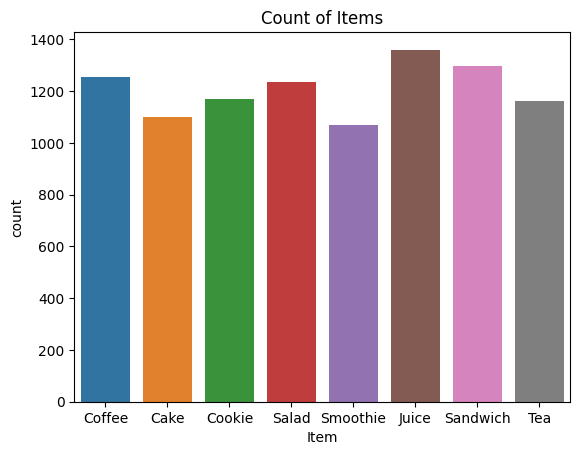

In [32]:
sns.countplot(x='Item',data=df)
plt.title('Count of Items') 
# we can see that the Juice is the most order while smoothie being least ordered

Text(0.5, 1.0, 'Count of Locations')

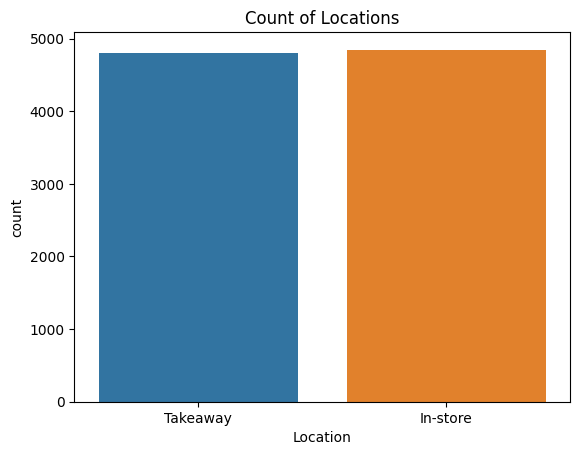

In [33]:
sns.countplot(x='Location',data=df)
plt.title('Count of Locations') 
# both store and takeaway are nearly the same which suggest improvment to the enviroment of store as more customers in store the more they will spend 

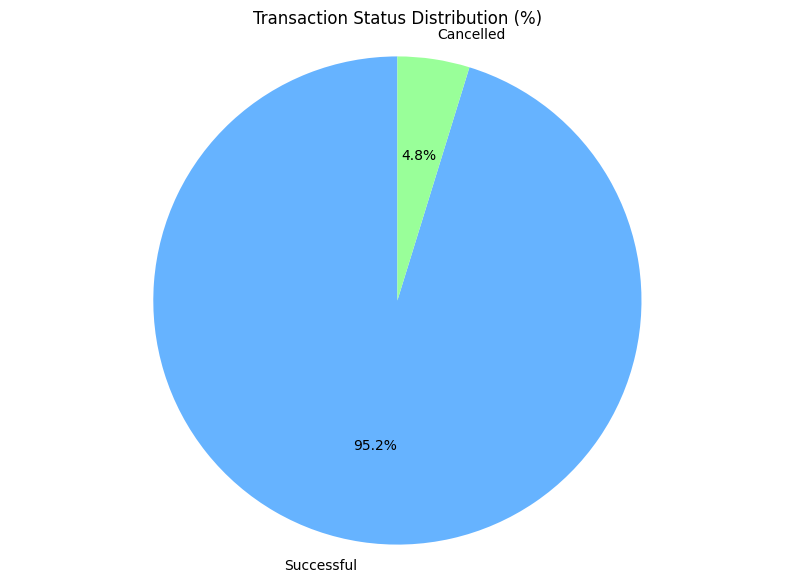

In [34]:
# Calculate percentages
status_counts = df['Transaction_Status'].value_counts(normalize=True) * 100  
# Create pie chart
plt.figure(figsize=(10, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Transaction Status Distribution (%)')
plt.axis('equal') # Equal aspect ratio to keep the pie circular
plt.show() 
# only 5% of transaction are cancelled 

Text(0.5, 1.0, 'Count of Payment Methods')

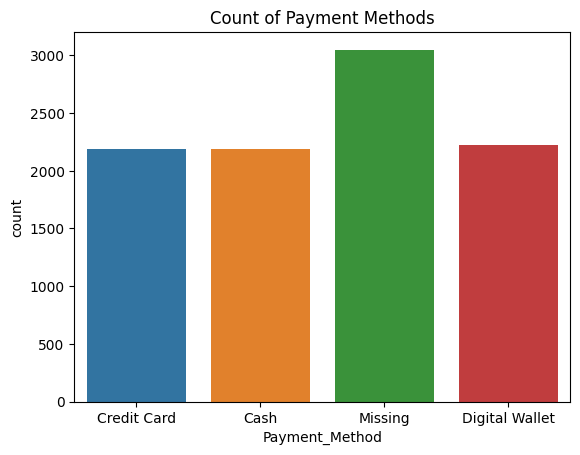

In [35]:
sns.countplot(x='Payment_Method',data=df)
plt.title('Count of Payment Methods')  
# this Shows the customers prefer to hide the payment method but with the available data it shows it is nearly equal 

###### we can see that a large amount of people decide not to say their payment method

#### Visualizing the Numerical values

Text(0.5, 1.0, 'Distribution of Quantity')

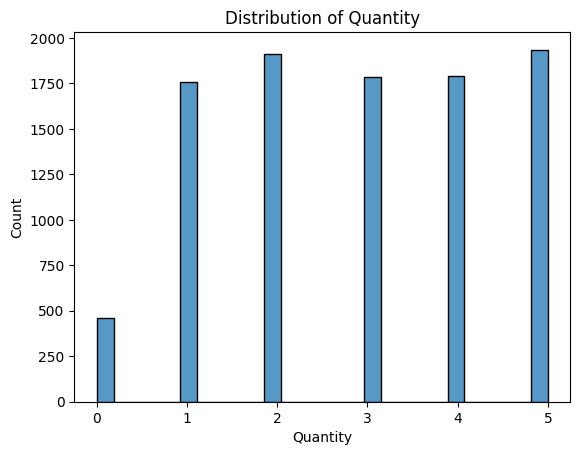

In [36]:
sns.histplot(x='Quantity', data=df)
plt.title('Distribution of Quantity')  
# this is very important as it shows customer tends to buy large quantity of 5 than any other quantity 

Text(0.5, 1.0, 'Distribution of Total_Spent')

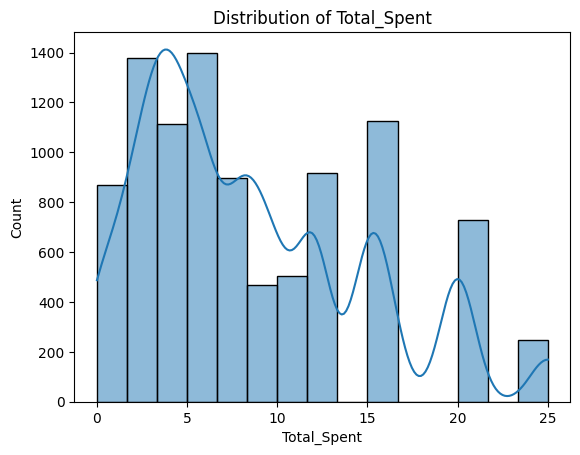

In [37]:
sns.histplot(x='Total_Spent',bins=15, data=df,kde=True)
plt.title('Distribution of Total_Spent') 
# This shows that the Total spent values is skewed to the right , it indicates that most transactions have a low value , with a smaller number of transactions having a much higher value.

## Bivariate Analysis

#### Visualizing numerical vs categorical data

In [38]:
df.columns # to check the columns in the dataframe

Index(['Item', 'Quantity', 'Unit_Price', 'Total_Spent', 'Payment_Method',
       'Location', 'Transaction_Date', 'Transaction_Status'],
      dtype='object')

Text(0.5, 1.0, 'Total Spent by Item')

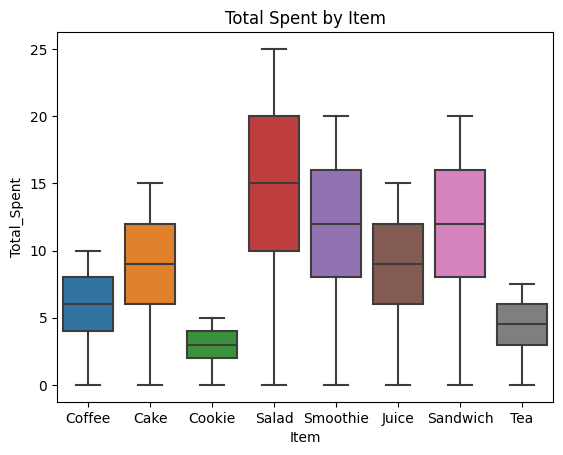

In [39]:
sns.boxplot(x='Item', y='Total_Spent', data=df)
plt.title('Total Spent by Item')
# there is no outliers in the Total Spent by Item, which is good, it means that the data is clean and there is no erroneous data in the Total Spent column
# salad and smoothies have the highest mdeian indicating they are generally associated with higher spending
# while coffee and tea have lower median spending indicating they are generally associated with lower spending.

Text(0.5, 1.0, 'Total Spent by Payment Method')

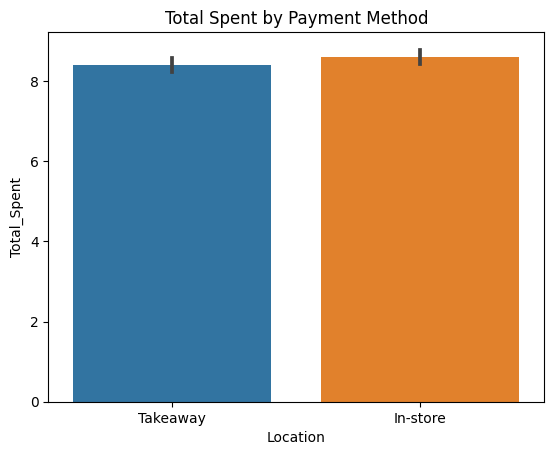

In [40]:
sns.barplot(x='Location', y='Total_Spent', data=df)
plt.title('Total Spent by Payment Method') 
# this shows that the total spent is slightly higher in store than takeaway

Text(0.5, 1.0, 'Total Spent Over Time')

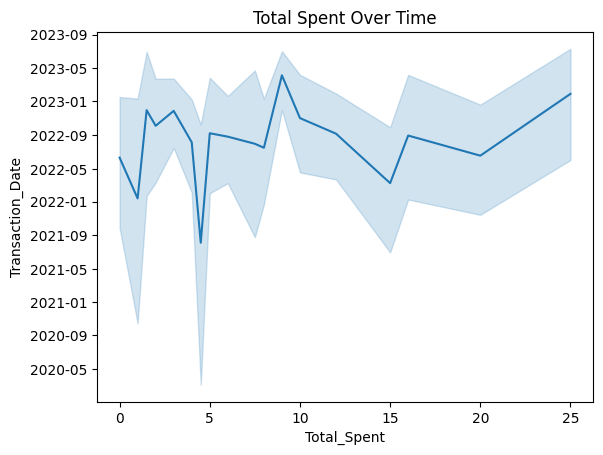

In [41]:
sns.lineplot(x='Total_Spent', y='Transaction_Date', data=df)
plt.title('Total Spent Over Time') 
# This shows the trend of total spent over time, whice started increasing the the last few months of 2022
# This indicates that the cafe has been performing well in the last few months of 2022 
# that maybe as due to coronavirus restrictions being lifted and people returning to cafes and restaurants.

#### Visualizing numerical vs numerical data

Text(0.5, 1.0, 'Unit Price vs Quantity')

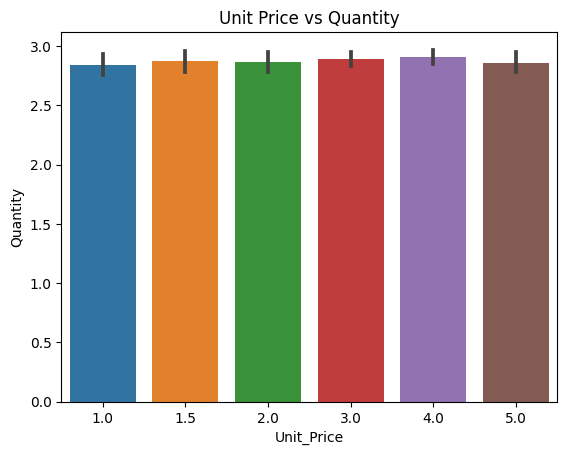

In [42]:
sns.barplot(x='Unit_Price', y='Quantity', data=df)
plt.title('Unit Price vs Quantity')
# this shows that Quantity is the same for all unit prices 
# indicationg that the price does not affect the quantity purchased, which is expected as customers generally buy the same quantity regardless of the price of the item.

Text(0.5, 1.0, 'Total Spent vs Quantity')

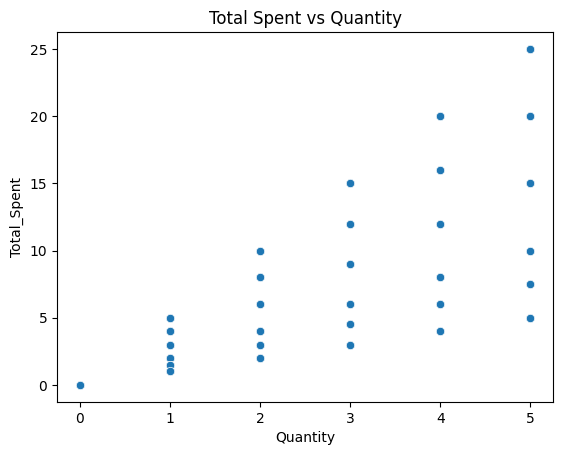

In [43]:
sns.scatterplot(x='Quantity',y='Total_Spent',data=df)
plt.title('Total Spent vs Quantity')
# This makes alot of sense as the quantity increase the total spent increase 

#### visualizing numerical vs categorical data 

Text(0.5, 1.0, 'Payment Method by Location')

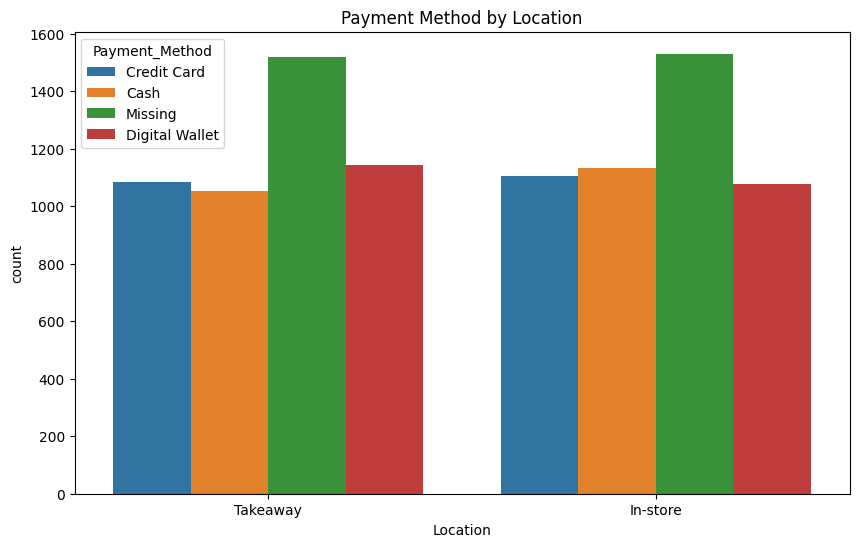

In [44]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Location', hue='Payment_Method', data=df)
plt.title('Payment Method by Location') 
# this shows that customers tend to pay using credit card or digitial wallet in takeway than cash 

Text(0.5, 1.0, 'Payment Method by Transaction_Status')

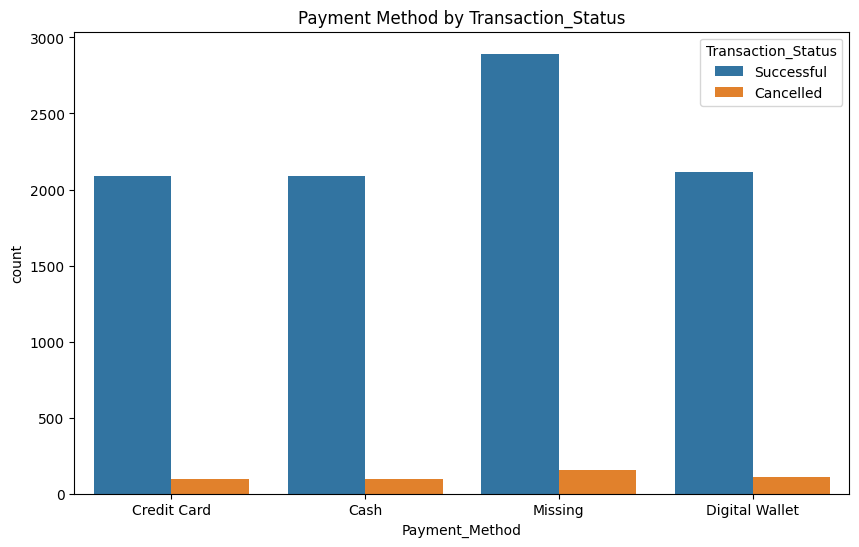

In [45]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Payment_Method', hue='Transaction_Status', data=df)
plt.title('Payment Method by Transaction_Status') 
# The vast majority of transactions, regardless of payment method, are successful
#The proportion of cancelled transactions appears to be relatively consistent across all payment methods. 
# There isn't a single payment method that seems to have a disproportionately high rate of cancelled transactions.
# That means that the cancelation is from the customer not due to technical problem or bad customer service

Text(0.5, 1.0, 'Payment Method by Location')

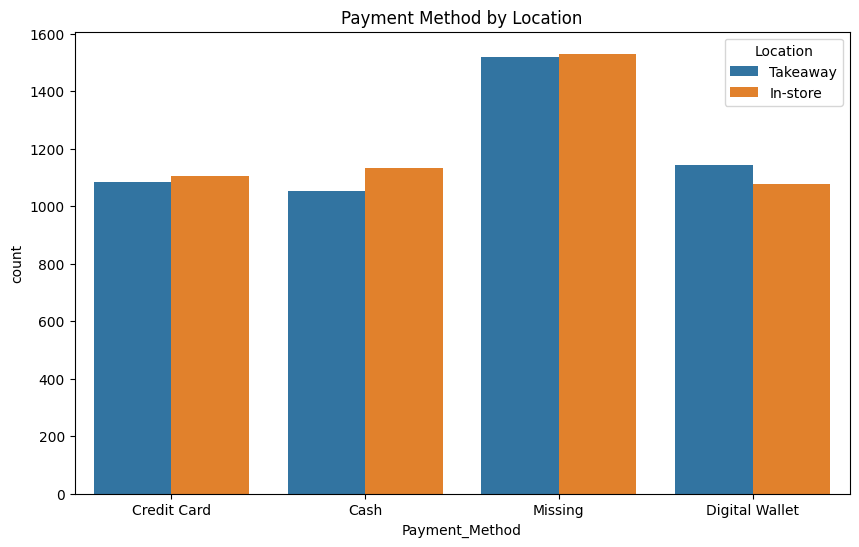

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Payment_Method', hue='Location', data=df)
plt.title('Payment Method by Location') 
# We see Cash and credit card is more in store   
# while digital wallet is more in takeaway that maybe becuase customer are in a hurry

<AxesSubplot:xlabel='Location'>

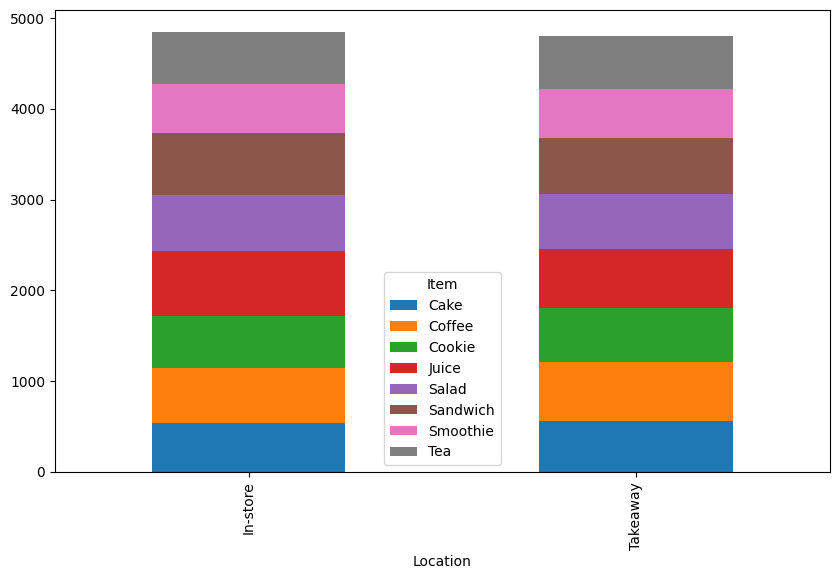

In [47]:
cross_tab = pd.crosstab(df['Location'], df['Item'])
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6)) 
# items does not differ wether it is in store or takeaway with tea being the most orderd and cake being least ordered

## Feature Correlation 

<AxesSubplot:>

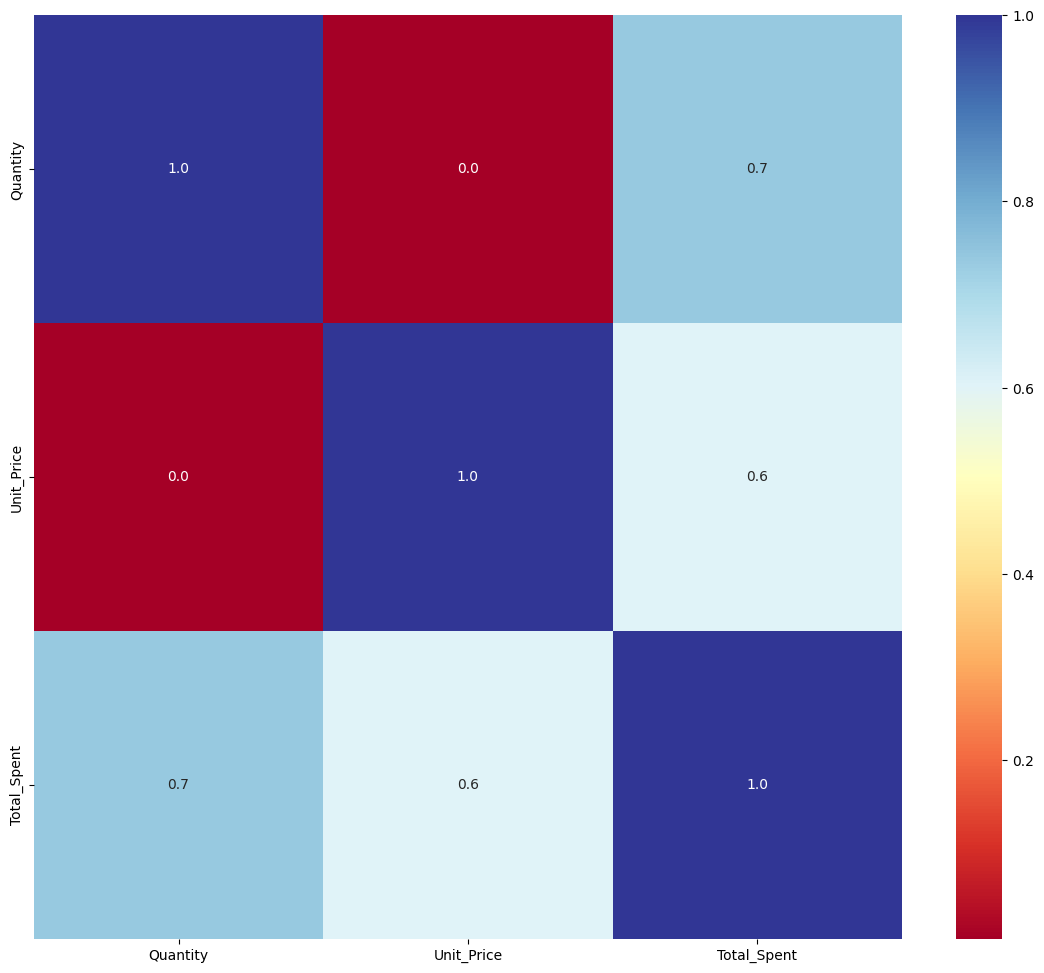

In [48]:
num_features=df.select_dtypes('number')
plt.figure(figsize=(14, 12))
correlation_matrix=num_features.corr()
sns.heatmap(correlation_matrix,cmap='RdYlBu',fmt=".1f",annot=True)
# This shows a great correlation between quantity and total spent which makes alot of sense
#This also shows a great correlation between unit price and total spent whice also makes alot of sense 
# Quantity and unit price is not related at all as their is nothing in common between them 

## __Conclusion__
####  This EDA provided valuable insights into the Dirty Cafe dataset, including customer behavior, sales trends, and key performance factors. After cleaning the data by handling missing values and inconsistencies, patterns emerged that can guide business decisions—such as identifying popular items, understanding peak sales periods, and evaluating payment method preferences. These findings can help the cafe optimize its operations, enhance customer satisfaction, and ultimately increase profitability.

In [49]:
df.to_csv("Datset_After_cleaning")